# Import Shipment Lead Time Prediction

This paper focuses on developing a predictive model for estimating the shipment lead time using machine learning methods for Ocean import freight considering interests of different stakeholders such as Supplier, Freight Forwarder, Port of Loading, LCL/FCL and Clearing Agent.

### Import libraries

In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from scipy.stats import probplot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2_contingency
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### Import Sea Shipment Details

In [2]:
sea_data = pd.read_excel("QB Shipment_Bookings - Sea.xlsx")

In [3]:
pd.set_option('display.max_columns', None)
sea_data.head(2)

,FORWARDER,ACCOUNT HOLDER,SHIPMENT UNIQUE NO,SUPPLIER NAME,SBU,P.O.#,MERCHANT NAME,BOOKING CONFIRMED DATE TO LFF,INCOTERM,PORT OF LOADING,WEIGHT IN KGS,ACTUAL NO OF PACKAGES,ACTUAL CBM,LCL/FCL,VESSEL/VOYAGE,ETD,ETA,Revised ETA Destination,ATD,ATA,BL NO.,CONTAINER NUMBER,DOCUMENT STATUS,DELIVERY LOCATION,PAYMENT TERM,DOCS TO CLEARING AGENT,APPROX CLEARANCE DATE,CFSCutoff Date and Time (GOODS),CYCutoff Date and Time,SHIPMENT CLEARED DATE,CLEARING AGENT
0,Expolanka Freight (Pvt) Ltd,Madhawa Ranganath,00018321-2023,TEEJAY INDIA PRIVATE LIMITED,BLI,9726186,Irumi,2023-04-03 14:43:00,EXW,VISAKHAPATNAM,NaN,NaN,NaN,FCL,SM NEYYAR V.0046,2023-04-06,2023-04-11,NaT,NaT,NaT,NaN,NaN,NaN,WATHUPITIWELA,NaN,NaT,2023-04-14,2023-04-03 00:00:00,2023-04-05,NaT,Brandix
1,Vinflair,Induka Hettiarachchi,00017305-2023,"CHUPA SHANGHAI CO.,LTD",BAI,B23243116,CHANDRA,2023-02-20 10:34:00,FOB,SHENZEN,101.64,8,0.547,LCL,INTERASIA ENHANCE W021,2023-02-28,2023-03-12,2023-03-13,2023-03-02,NaT,SZSE23020199,CSLU1148377\n,NaN,BAI2,NaN,NaT,2023-03-17,2023-02-21 00:00:00,2023-02-25,NaT,KSR


In [4]:
sea_data["Mode"] = "Sea"

In [5]:
sea_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5157 entries, 0 to 5156
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   FORWARDER                        5157 non-null   object        
 1   ACCOUNT HOLDER                   5157 non-null   object        
 2   SHIPMENT UNIQUE NO               5157 non-null   object        
 3   SUPPLIER NAME                    5157 non-null   object        
 4   SBU                              5157 non-null   object        
 5   P.O.#                            5157 non-null   object        
 6   MERCHANT NAME                    5155 non-null   object        
 7   BOOKING CONFIRMED DATE TO LFF    5157 non-null   datetime64[ns]
 8   INCOTERM                         5157 non-null   object        
 9   PORT OF LOADING                  5157 non-null   object        
 10  WEIGHT IN KGS                    3085 non-null   object     

In [6]:
sea_data['Ageing'] = (sea_data['Revised ETA Destination']- sea_data['CYCutoff Date and Time']).dt.days

### Exploratory Data Analysis

In [7]:
profile = ProfileReport(sea_data,explorative=True)

# Display the profile report
profile.to_file('Exploratory Analysis.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Select Columns

In [8]:
df_sea = sea_data[['FORWARDER', 'SUPPLIER NAME', 'PORT OF LOADING', 'SBU', 'DOCUMENT STATUS', 'CYCutoff Date and Time', 'Ageing',]]

In [9]:
df_sea = df_sea.dropna(how='any',axis=0)
df_sea.head(2)

,FORWARDER,SUPPLIER NAME,PORT OF LOADING,SBU,DOCUMENT STATUS,CYCutoff Date and Time,Ageing
3,Expolanka Freight (Pvt) Ltd,EURO JERSEY S.P.A,GENOVA,BAI,Surrendered,2023-03-04,37.0
9,20 Cube ( Pvt ) Ltd,"BAIKAI INDUSTRY (VIETNAM) CO., LTD.",HO CHI MINH CITY,BLI,Surrendered,2023-03-26,9.0


In [10]:
df_sea.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1520 entries, 3 to 5141
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   FORWARDER               1520 non-null   object        
 1   SUPPLIER NAME           1520 non-null   object        
 2   PORT OF LOADING         1520 non-null   object        
 3   SBU                     1520 non-null   object        
 4   DOCUMENT STATUS         1520 non-null   object        
 5   CYCutoff Date and Time  1520 non-null   datetime64[ns]
 6   Ageing                  1520 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 95.0+ KB


## Remove Outliers

Removing outliers from a dataset can be done in several ways, but one common approach is to use the Interquartile Range (IQR) method. The IQR is a measure of statistical dispersion and represents the range between the first and third quartiles of a dataset. The IQR is used to identify the boundaries of the "normal" range of data, and any data points outside of these boundaries are considered outliers.

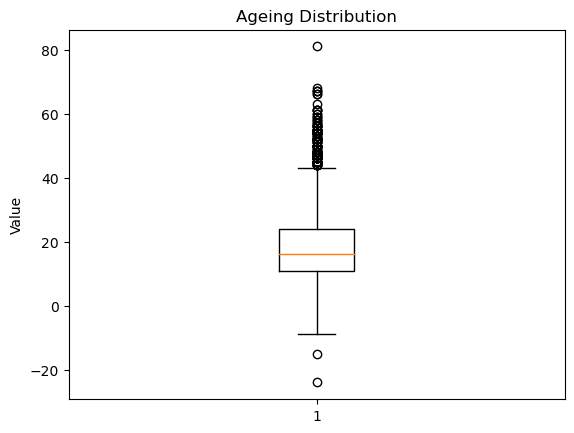

In [11]:
fig, ax = plt.subplots()
ax.boxplot(df_sea['Ageing'])

# Add a title and y-axis label
ax.set_title('Ageing Distribution')
ax.set_ylabel('Value')

# Show the plot
plt.show()

Since Ageing should be posistive value need to remove negative value form data set

In [12]:
# Filter negative value in ageing
df_sea = df_sea[(df_sea['Ageing'] >= 0)]

In [13]:
# Calculate the first and third quartiles and the IQR
Q1 = df_sea['Ageing'].quantile(0.25)
Q3 = df_sea['Ageing'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds as 1.5 times the IQR below Q1 and above Q3, respectively
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out any values below the lower bound or above the upper bound
df_filtered = df_sea[(df_sea['Ageing'] >= lower_bound) & (df_sea['Ageing'] <= upper_bound)]
df_filtered.head(2)

,FORWARDER,SUPPLIER NAME,PORT OF LOADING,SBU,DOCUMENT STATUS,CYCutoff Date and Time,Ageing
3,Expolanka Freight (Pvt) Ltd,EURO JERSEY S.P.A,GENOVA,BAI,Surrendered,2023-03-04,37.0
9,20 Cube ( Pvt ) Ltd,"BAIKAI INDUSTRY (VIETNAM) CO., LTD.",HO CHI MINH CITY,BLI,Surrendered,2023-03-26,9.0


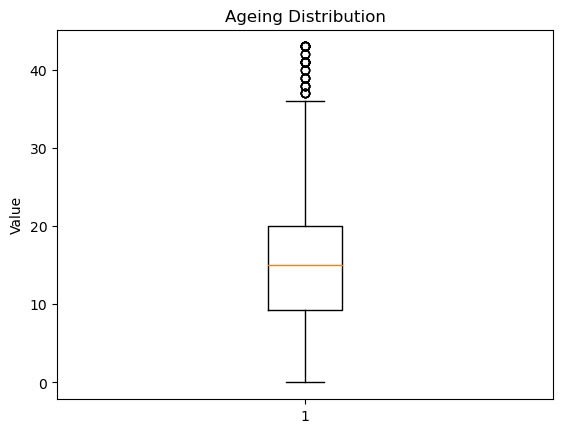

In [14]:
fig, ax = plt.subplots()
ax.boxplot(df_filtered['Ageing'])

# Add a title and y-axis label
ax.set_title('Ageing Distribution')
ax.set_ylabel('Value')

# Show the plot
plt.show()

In [15]:
df_filtered.describe()

,Ageing
count,1322.000000
mean,15.900908
std,8.506400
min,0.000000
25%,9.250000
50%,15.000000
75%,20.000000
max,43.000000


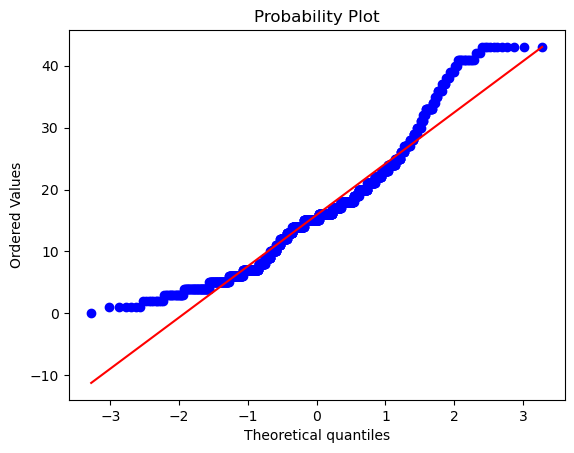

In [16]:
# Create a normal probability plot of the sample
probplot(df_filtered['Ageing'], plot=plt)

# Show the plot
plt.show()

## Feature Engineering

### Feature Extraction

Feature extraction is the process of identifying and selecting the most relevant and informative features (or variables) from raw data. It is an important step in machine learning because it reduces the dimensionality of the data and helps in improving the accuracy and efficiency of the model.

In [17]:
df_filtered.head(2)

,FORWARDER,SUPPLIER NAME,PORT OF LOADING,SBU,DOCUMENT STATUS,CYCutoff Date and Time,Ageing
3,Expolanka Freight (Pvt) Ltd,EURO JERSEY S.P.A,GENOVA,BAI,Surrendered,2023-03-04,37.0
9,20 Cube ( Pvt ) Ltd,"BAIKAI INDUSTRY (VIETNAM) CO., LTD.",HO CHI MINH CITY,BLI,Surrendered,2023-03-26,9.0


CY Cutoff Day is the critical date for shipment. All shipment planes made base on CY Cutoff, therfore, here extract Month, Week number and Day features.

In [18]:
#Create variable with weeknumber for CYCutoff
df_filtered['weekNumber'] = df_filtered['CYCutoff Date and Time'].dt.week

#Create variable with month for CYCutoff
df_filtered['month_of_date'] = df_filtered['CYCutoff Date and Time'].dt.month

#Create variable with day for CYCutoff
df_filtered['day_of_date'] = df_filtered['CYCutoff Date and Time'].dt.dayofweek

In [19]:
df_filtered.head(2)

,FORWARDER,SUPPLIER NAME,PORT OF LOADING,SBU,DOCUMENT STATUS,CYCutoff Date and Time,Ageing,weekNumber,month_of_date,day_of_date
3,Expolanka Freight (Pvt) Ltd,EURO JERSEY S.P.A,GENOVA,BAI,Surrendered,2023-03-04,37.0,9,3,5
9,20 Cube ( Pvt ) Ltd,"BAIKAI INDUSTRY (VIETNAM) CO., LTD.",HO CHI MINH CITY,BLI,Surrendered,2023-03-26,9.0,12,3,6


In [20]:
#drop CYcutoff date variable
df_filtered = df_filtered.drop('CYCutoff Date and Time', axis=1)

#reoder columns
df_filtered = df_filtered[['FORWARDER', 'SUPPLIER NAME', 'PORT OF LOADING', 'SBU', 'DOCUMENT STATUS', 'weekNumber', 
                           'month_of_date', 'day_of_date', 'Ageing']]
df_filtered.head(2)

,FORWARDER,SUPPLIER NAME,PORT OF LOADING,SBU,DOCUMENT STATUS,weekNumber,month_of_date,day_of_date,Ageing
3,Expolanka Freight (Pvt) Ltd,EURO JERSEY S.P.A,GENOVA,BAI,Surrendered,9,3,5,37.0
9,20 Cube ( Pvt ) Ltd,"BAIKAI INDUSTRY (VIETNAM) CO., LTD.",HO CHI MINH CITY,BLI,Surrendered,12,3,6,9.0


### Encording Data

In [21]:
df_encode = df_filtered.copy()

In [22]:
# Create a LabelEncoder object
encoder = LabelEncoder()

# Encode a categorical variable
df_encode['FORWARDER'] = encoder.fit_transform(df_encode['FORWARDER'])
df_encode['SUPPLIER NAME'] = encoder.fit_transform(df_encode['SUPPLIER NAME'])
df_encode['PORT OF LOADING'] = encoder.fit_transform(df_encode['PORT OF LOADING'])
df_encode['SBU'] = encoder.fit_transform(df_encode['SBU'])
df_encode['DOCUMENT STATUS'] = encoder.fit_transform(df_encode['DOCUMENT STATUS'])

In [23]:
df_encode.head(2)

,FORWARDER,SUPPLIER NAME,PORT OF LOADING,SBU,DOCUMENT STATUS,weekNumber,month_of_date,day_of_date,Ageing
3,3,50,5,2,2,9,3,5,37.0
9,0,14,8,10,2,12,3,6,9.0


### Feature Selection

#### Chi-squared

To test the association between each of the 7 categorical variables and the continuous target variable using the chi-squared test, first need to convert the continuous variable into a categorical variable by binning or discretizing it into appropriate categories. Then perform a separate chi-squared test for each of the 4 categorical variables against the discretized target variable.

In [24]:
# Discretize the target variable into 3 categories using the qcut function
df_encode['Ageing_category'] = pd.qcut(df_encode['Ageing'], q=5)

# Perform chi-squared tests for each categorical variable against the discretized target variable
for cat_var in ['FORWARDER', 'SUPPLIER NAME', 'SUPPLIER NAME', 'DOCUMENT STATUS', 'SBU', 'weekNumber', 'month_of_date', 'day_of_date']:
    contingency_table = pd.crosstab(df_encode[cat_var], df_encode['Ageing_category'])
    chi2, pval, dof, exp_freq = chi2_contingency(contingency_table)
    print(f"{cat_var}: chi2={chi2:.2f}, p-value={pval:.4f}")

FORWARDER: chi2=694.81, p-value=0.0000
SUPPLIER NAME: chi2=2062.12, p-value=0.0000
SUPPLIER NAME: chi2=2062.12, p-value=0.0000
DOCUMENT STATUS: chi2=346.64, p-value=0.0000
SBU: chi2=480.27, p-value=0.0000
weekNumber: chi2=628.91, p-value=0.0000
month_of_date: chi2=268.74, p-value=0.0000
day_of_date: chi2=305.71, p-value=0.0000


All the P-Values are less than 0.05, therfore, reject the null hypothesis of independence and we can conclude that there is a statistically significant association between the variables with Ageing.

But to improve the accuracy of the model will remove lowest chi value feature from data set.

In [25]:
#drop month_of_date variable
df_filtered = df_filtered.drop('month_of_date', axis=1)

## Spliting Data

Splitting the dataset is a common technique used in machine learning to evaluate the performance of a model. It involves dividing a dataset into two or more parts, typically a training set and a test set, to train and validate a model.

The training set is used to train the model, while the test set is used to evaluate its performance. The goal of splitting the dataset is to simulate how well the model can generalize to new, unseen data.

In [26]:
df_encode.head()

,FORWARDER,SUPPLIER NAME,PORT OF LOADING,SBU,DOCUMENT STATUS,weekNumber,month_of_date,day_of_date,Ageing,Ageing_category
3,3,50,5,2,2,9,3,5,37.0,"(21.0, 43.0]"
9,0,14,8,10,2,12,3,6,9.0,"(8.0, 14.0]"
10,0,101,25,2,1,9,3,4,22.0,"(21.0, 43.0]"
14,9,94,9,7,2,10,3,4,14.0,"(8.0, 14.0]"
15,9,134,9,7,2,11,3,4,15.0,"(14.0, 17.0]"


In [27]:
df_encode = df_encode.drop('Ageing_category', axis=1)

In [28]:
# separate the features and the target variable
X = df_encode.iloc[:, :-1]   # categorical variables
y = df_encode.iloc[:, -1]    # continuous target variable

# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model selection

Choose a suitable machine learning algorithm for dataset. Since this dataset have a categorical target variable, we can use classification algorithms such as logistic regression, decision trees, or random forests.

### Logistic Regression

In [29]:
# create a logistic regression model
Logistic_model = LogisticRegression()

# train the model on the training set
Logistic_model.fit(X_train, y_train)

# evaluate the model on the testing set
score = Logistic_model.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.13962264150943396


### Decision Tree 

In [30]:
# create a decision tree model
Decision_model = DecisionTreeClassifier()

# train the model on the training set
Decision_model.fit(X_train, y_train)

# evaluate the model on the testing set
score = Decision_model.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.3886792452830189


### Random Forests

In [31]:
# create a random forest model with 100 trees
Random_model = RandomForestClassifier(n_estimators=100)

# train the model on the training set
Random_model.fit(X_train, y_train)

# evaluate the model on the testing set
score = Random_model.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.3584905660377358


### Gradient Boosting

In [32]:
# create a gradient boosting model with 100 trees
Gradient_model = GradientBoostingClassifier(n_estimators=100)

# train the model on the training set
Gradient_model.fit(X_train, y_train)

# evaluate the model on the testing set
score = Gradient_model.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.3849056603773585


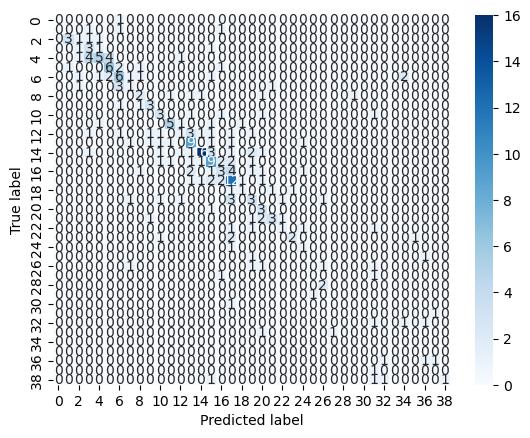

In [33]:
# make predictions on the testing set
y_pred = Gradient_model.predict(X_test)

# compute the classification report and confusion matrix
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

## Hyperparameter Selection

To Optimize model's hyperparameters to improve its performance this is important step in machine learning to optimize the performance of a model. Perform hyperparameter tuning for above performed models.

### Logistic Regression

To perform hyperparameter tuning for logistic regression, here use a grid search to test different combinations of hyperparameters and select the ones that give the best performance.

In [34]:
# define the hyperparameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# perform a grid search to find the best hyperparameters
grid = GridSearchCV(Logistic_model, param_grid, cv=5)
grid.fit(X_train, y_train)

# print the best hyperparameters
print(grid.best_params_)

{'C': 0.01}


### Decision Trees

To perform hyperparameter tuning for decision trees, here use a grid search to test different combinations of hyperparameters and select the ones that give the best performance.

In [35]:
# define the hyperparameter grid
param_grid = {'max_depth': [2, 4, 6, 8, 10],
              'min_samples_split': [2, 4, 6, 8, 10],
              'min_samples_leaf': [1, 2, 3, 4, 5]}

# perform a grid search to find the best hyperparameters
grid = GridSearchCV(Decision_model, param_grid, cv=5)
grid.fit(X_train, y_train)

# print the best hyperparameters
print(grid.best_params_)

{'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 6}


### Random Forests

To perform hyperparameter tuning for random forests, here use a grid search to test different combinations of hyperparameters and select the ones that give the best performance

In [36]:
# define the hyperparameter grid
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [2, 4, 6, 8, 10],
              'min_samples_split': [2, 4, 6, 8, 10],
              'min_samples_leaf': [1, 2, 3, 4, 5]}

# perform a grid search to find the best hyperparameters
grid = GridSearchCV(Random_model, param_grid, cv=5)
grid.fit(X_train, y_train)

# print the best hyperparameters
print(grid.best_params_)

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 200}


## Optimize Models

### Logistic Regression

To optimize a logistic regression model using the best hyperparameters found by a grid search, here simply create a new logistic regression model with those hyperparameters and fit it to the training data.

In [59]:
# create a logistic regression model with the best hyperparameters
Opt_Logic_model = LogisticRegression(C=0.01)

# fit the model to the training data
Opt_Logic_model.fit(X_train, y_train)

# evaluate the model on the testing set
lr_predict = Opt_Random_model.predict(X_test)

# perform 10-fold cross-validation
scores = cross_val_score(Opt_Logic_model, X, y, cv=100)
lr_precision = precision_score(y_test, lr_predict, average='micro')

# print the mean and standard deviation of the cross-validation scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Precision: " ,lr_precision.mean())

Accuracy: 0.13 (+/- 0.15)
Precision:  0.3660377358490566


### Decision Trees

To optimize a decision tree model using the best hyperparameters found by a grid search, here create a new decision tree model with those hyperparameters and fit it to the training data

In [58]:
# create a decision tree model with the best hyperparameters
Opt_Decision_model = DecisionTreeClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=6)

# fit the model to the training data
Opt_Decision_model.fit(X_train, y_train)

# evaluate the model on the testing set
dt_predict = Opt_Random_model.predict(X_test)

# perform 10-fold cross-validation
scores = cross_val_score(Opt_Decision_model, X, y, cv=100)
dt_mae = mean_absolute_error(y_test, dt_predict)
dt_rmse = mean_squared_error(y_test, dt_predict, squared=False)
dt_precision = precision_score(y_test, dt_predict, average='micro')

# print the mean and standard deviation of the cross-validation scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("MAE: " ,dt_mae.mean())
print("MSE: " ,dt_rmse.mean())
print("Precision: " ,dt_precision.mean())

Accuracy: 0.34 (+/- 0.25)
MAE:  3.120754716981132
MSE:  5.890510436927106
Precision:  0.3660377358490566


### Random Forests

To optimize a random forest model using the best hyperparameters found by a grid search, here create a new random forest model with those hyperparameters and fit it to the training data.

In [57]:
# create a random forest model with the best hyperparameters
Opt_Random_model = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=1, min_samples_split=4)

# fit the model to the training data
Opt_Random_model.fit(X_train, y_train)

# evaluate the model on the testing set
rf_predict = Opt_Random_model.predict(X_test)

# perform 10-fold cross-validation
scores = cross_val_score(Opt_Random_model, X, y, cv=100)
rf_mae = mean_absolute_error(y_test, rf_predict)
rf_rmse = mean_squared_error(y_test, rf_predict, squared=False)
rf_precision = precision_score(y_test, dt_predict, average='micro')

# print the mean and standard deviation of the cross-validation scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("MAE: " ,rf_mae.mean())
print("MSE: " ,rf_rmse.mean())
print("Precision: " ,rf_precision.mean())

Accuracy: 0.40 (+/- 0.25)
MAE:  3.120754716981132
MSE:  5.890510436927106
Precision:  0.3584905660377358


## Model Training and Evaluation

Here we have train above models with training datasets by spliting for 100 times and calculate model accuracies by using 'accuracy_score' in scikit-learn. It compares the predicted labels with the true labels and returns the fraction of correct predictions.

The formula for accuracy score is:

#### Accuracy = (number of correct predictions) / (total number of predictions)

    

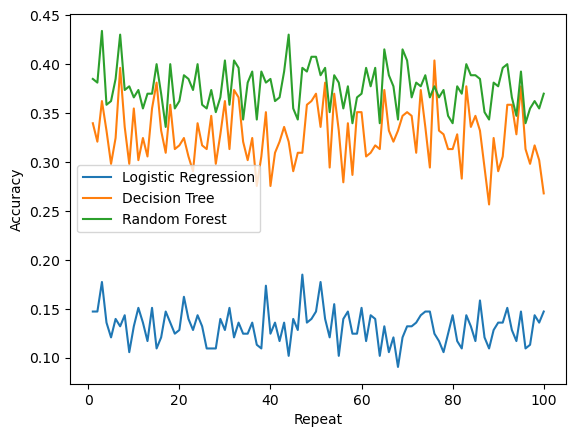

<Figure size 640x480 with 0 Axes>

In [60]:
# create arrays to store the scores for each model
lr_scores = np.zeros((100, 1))
dt_scores = np.zeros((100, 1))
rf_scores = np.zeros((100, 1))

# repeat the process 100 times
for i in range(100):
    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    
    # train the logistic regression model
    Opt_Logic_model.fit(X_train, y_train)
    lr_pred = Opt_Logic_model.predict(X_test)
    lr_scores[i] = accuracy_score(y_test, lr_pred)
    
    # train the decision tree model
    Opt_Decision_model.fit(X_train, y_train)
    dt_pred = Opt_Decision_model.predict(X_test)
    dt_scores[i] = accuracy_score(y_test, dt_pred)
    
    # train the random forest model
    Opt_Random_model.fit(X_train, y_train)
    rf_pred = Opt_Random_model.predict(X_test)
    rf_scores[i] = accuracy_score(y_test, rf_pred)

# create a list of model names
models = ['Logistic Regression', 'Decision Tree', 'Random Forest']

# create a list of the scores for each model
scores = [lr_scores, dt_scores, rf_scores]

# plot a line chart of the mean score for each model over 100 repeats
for i, score in enumerate(scores):
    plt.plot(np.arange(1, 101), np.mean(score, axis=1), label=models[i])

# add a legend to the chart
plt.legend()

# add axis labels
plt.xlabel('Repeat')
plt.ylabel('Accuracy')

# show the chart
plt.show()
plt.savefig('Accuracy.png')

In [61]:
plt.savefig('Accuracy.png')

<Figure size 640x480 with 0 Axes>